# <u> Content-based Filtering</u>


As an alternative to collaborative filtering explored in previous notebooks, **content-based filtering** relies on the intrinsic features of items rather than user–item interactions across the entire population. The main idea is to represent each movie as a **feature vector** capturing its attributes, and to construct a **user profile** by aggregating the features of movies the user has previously liked. The predicted preference for a new movie is then determined by the **similarity** between the user profile and the movie feature vector.

<br>

Mathematically, the predicted score for a user $u$ on an unseen movie $m$ can be expressed as

<br>

$$
\hat{r}_{u,m} = \text{scale}\Big(\text{sim}(\text{user\_profile}_u, \text{movie\_vector}_m)\Big)
$$

<br>

where  

- $\text{user\_profile}_u \in \mathbb{R}^d$ is the vector representing user $u$’s preferences;  
- $\text{movie\_vector}_m \in \mathbb{R}^d$ is the vector describing movie $m$;  
- $\text{sim}(\cdot,\cdot)$ is a similarity measure, such as **cosine similarity and dot product**;  
- $\text{scale}(\cdot)$ is a linear transformation that maps the similarity score to the rating range (0.5-5) by matching the original rating scale.  

<br>

This approach allows the recommender system to suggest movies that are **most similar to what the user already enjoys**. The method is particularly useful for capturing individual tastes, and handling situations where user interactions and overlapping with other users are limited. In practice, the quality of the recommendations depends mostly on the richness and relevance of the item features used to construct the user profile. 


## <u>0. Setting:</u>

### <u>0.1 Import libraries</u>

In [1]:
# Import necessary libraries
import pandas as pd, numpy as np, os, sys
import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import itertools

# Remove userwarnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Set random seed for reproducibility
np.random.seed(12)

# Set the working directory
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

### <u>0.2 Import pre-built datasets</u>

As a comparative study with the memory-based and model-based collaborative system, we use the same **train–validation–test split** based on time. For each user, the **earliest 70% of their ratings** are used for training, the **next 10% for validation**, and the **most recent 20% for testing**. This ensures a fair comparison between different models without introducing bias in the evaluation set. Given the nature of the algorithm, which does not incorporate any content-based information about the movies, only the `userId`, `movieId`, and `rating` columns are used for training. Following the memory-based evaluation, RMSE is recorded on the full test set as well as separately for **warm-start** and **cold-start** subsets. Hyperparameter tuning is performed on the validation set, and total training and evaluation time is reported for computation comparison.



In [2]:
#Load dataframe over the columns of interest
train_df = pd.read_csv('../data/processed/train_df.csv')
val_df = pd.read_csv('../data/processed/val_df.csv')
test_df = pd.read_csv('../data/processed/test_df.csv')
warm_test_df = pd.read_csv('../data/processed/warm_test_df.csv')
cold_test_df = pd.read_csv('../data/processed/cold_test_df.csv')


In [3]:
train_df.head(3)

,userId,movieId,rating
0,27,2683,5.0
1,27,2997,3.0
2,27,1527,2.5


## <u>1. Similarity</u>



In this experiment, we use **cosine similarity** as the measure of similarity between the user profile and an unseen movie vector. The motivation for this choice lies in how cosine similarity emphasizes **alignment in feature space** rather than absolute magnitude. In this implementation, the user profile is constructed as a weighted aggregation of movie feature vectors, where the weights correspond to the ratings assigned by the user. Although this aggregation is normalized by the sum of the weights, the resulting vector may still exhibit differences in magnitude due to variations in how concentrated or diverse a user’s preferences are across feature dimensions. As a result, similarity measures that are sensitive to vector magnitude, such as the dot product, may assign systematically higher scores to users whose profiles have larger norms, regardless of how well the underlying feature patterns align.

Mathematically, the cosine similarity between the user profile vector $\mathbf{u}$ and a movie feature vector $\mathbf{m}$ is defined as

<br>

$$
\text{sim}_{\text{cosine}}(\mathbf{u}, \mathbf{m}) = 
\frac{\mathbf{u} \cdot \mathbf{m}}{\|\mathbf{u}\| \, \|\mathbf{m}\|}
$$

where $\|\cdot\|$ denotes the **Euclidean norm** of a vector.

## <u>2. Movie Vector</u>

Based on the exploratory data analysis conducted in `01_eda.ipynb`, several features have been identified for inclusion in our movie vector representation. In this notebook, the following features are implemented:

- **Movie genres**: The 19 distinct genres are encoded using **one-hot encoding**, providing a categorical representation of the movie type.
- **Bayesian-adjusted rating**: This measure is included to capture the overall quality and community appraisal of a movie. It is preferred over the simple average rating, as it accounts for differences in popularity, exposure, and review count, thereby mitigating the influence of movies with very few ratings.
- **Decade of release**: The decade is derived from the release year to provide a coarse temporal context. This feature allows movies to be compared in terms of their production period, capturing similarity across time.
- **Year of release**: The year is extracted directly from the movie title and provides a more precise temporal context.
- **Tag relevance scores**: User-provided tags are incorporated as an additional source of content information. Given the large number of distinct tags (1128), variance-based filtering followed by **PCA** is applied to reduce dimensionality while retaining the most informative components for movie comparison.
- **Popularity**: The number of reviews is used to represent movie popularity. This feature captures the tendency of most users to watch widely-known movies while also allowing differentiation for those with niche tastes.

This combination of categorical, numerical, and derived features forms the basis of our content-based movie representation. Features are treated as distinct groups reflecting different aspects of movie content and are standardized independently. Similarity the similarities are computed in a group-aware manner, ensuring that no single feature type disproportionately influences the overall comparison.


### <u> 1.1 General metrics and genre </u>

As a first step, we construct and extract general movie-level features such as release year, decade, genre, popularity and Bayesian-adjusted rating. These features are computed exclusively from the training set to avoid any information leakage from the validation and test sets. The full procedure is implemented in the `01_eda.ipynb` notebook, which serves as a reference for both reproducibility and more detailed exploratory analysis.

In [4]:
# Unique movie IDs
train_movie_ids = set(train_df['movieId'].unique())
val_movie_ids = set(val_df['movieId'].unique())
test_movie_ids = set(test_df['movieId'].unique())

# Movies in val/test that are NOT in train by set difference
val_only_movies = val_movie_ids - train_movie_ids
test_only_movies = test_movie_ids - train_movie_ids
print(f"\nMovies in validation but not in training: {len(val_only_movies)}")
print(f"Movies in test but not in training: {len(test_only_movies)}")


# Print movieIds that are in val/test but not in train
val_test_overlap = val_only_movies & test_only_movies
print(f"Movies in both validation and test but not in training: {len(val_test_overlap)}")


Movies in validation but not in training: 2
Movies in test but not in training: 4
Movies in both validation and test but not in training: 2


Given the nature of the algorithm and the use of Bayesian-adjusted ratings computed over the training set, we verified that all movies in the validation and test sets are also present in the training set. However, a total of 4 movies do not meet this condition. To include these movies in the creation of the movie vectors, we assign them the average Bayesian-adjusted rating computed over the training set. This approach allows us to handle a very cold-start scenario during evaluation while maintaining comparability across models by preserving the original validation and test sets. Similarly, the number of reviews for movies not present in the training set is set to 0.


In [5]:
# Import movies dataframe
movies_df = pd.read_csv('../data/processed/movies.csv')

# Extract movie year from title as column and format it as integer
movies_df['year'] = movies_df['title'].str.extract(r'\((\d{4})\)').astype(float)

# Build decade column based on year
movies_df['decade'] = (movies_df['year'] // 10 * 10).astype('Int64')

# Build one-hot ecnoded genres
genres_dummies = movies_df['genres'].str.get_dummies(sep='|')

# Add prefix 'g_' to genre columns
genres_dummies = genres_dummies.add_prefix('G_')

# Concatenate the original movies_df with the genres_dummies
movies_df = pd.concat([movies_df, genres_dummies], axis=1)
movies_df.drop(columns=['genres'], inplace=True)
movies_df.drop(columns=['title'], inplace=True)

movies_df.head(3)

,movieId,year,decade,G_Action,G_Adventure,G_Animation,G_Children,G_Comedy,G_Crime,G_Documentary,...,G_Film-Noir,G_Horror,G_IMAX,G_Musical,G_Mystery,G_Romance,G_Sci-Fi,G_Thriller,G_War,G_Western
0,1,1995.0,1990,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1995.0,1990,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1995.0,1990,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [6]:

# Group movies by movieId: count and average rating
movie_stats = train_df.groupby('movieId').agg({'rating': ['count', 'mean']})
movie_stats.columns = ['rating_count', 'average_rating']
movie_stats = movie_stats.reset_index()

# Global averages from TRAINING set
m = movie_stats['rating_count'].mean()      
C = movie_stats['average_rating'].mean()

# Compute Bayesian-adjusted rating for each movie in the traininig set
movie_stats['Bayes_rating'] = (
    (movie_stats['rating_count'] / (movie_stats['rating_count'] + m)) * movie_stats['average_rating']
    + (m / (movie_stats['rating_count'] + m)) * C
)

movie_stats.head(3)

,movieId,rating_count,average_rating,Bayes_rating
0,1,1774,3.883878,3.854467
1,2,691,3.132417,3.149043
2,3,410,3.169512,3.188785


In [7]:
# Left join movies_df over movie_stats on movieId
movies_vector = pd.merge(
    movies_df,
    movie_stats,
    on='movieId',
    how='left'
)

# Rename rating_count to popularity
movies_vector.rename(columns={'rating_count': 'popularity'}, inplace=True)

# Drop average_rating column
movies_vector.drop(columns=['average_rating'], inplace=True)

movies_vector.head(2)

,movieId,year,decade,G_Action,G_Adventure,G_Animation,G_Children,G_Comedy,G_Crime,G_Documentary,...,G_IMAX,G_Musical,G_Mystery,G_Romance,G_Sci-Fi,G_Thriller,G_War,G_Western,popularity,Bayes_rating
0,1,1995.0,1990,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,1774.0,3.854467
1,2,1995.0,1990,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,691.0,3.149043


In [8]:
# Number of rows containing at least one NaN
rows_with_nan = movies_vector.isna().any(axis=1).sum()

# Total number of NaNs in the entire DataFrame
total_nans = movies_vector.isna().sum().sum()

print(f"Rows with at least one NaN: {rows_with_nan}")
print(f"Total NaNs in DataFrame: {total_nans}")

# Fill NaN values in popularity to 0
movies_vector['popularity'] = movies_vector['popularity'].fillna(0)

#Fill NaN values in Bayes_rating to the global bayesian average
mean_bayesian_rating = movies_vector['Bayes_rating'].mean()
movies_vector['Bayes_rating'] = movies_vector['Bayes_rating'].fillna(mean_bayesian_rating)

# Check for remaining NaN values
nan_counts = movies_vector.isna().sum().sum()
print(f"\nNumber of NaN values after filling: {nan_counts}")


Rows with at least one NaN: 4
Total NaNs in DataFrame: 8

Number of NaN values after filling: 0


### <u>1.2 Relevance score of tags</u>

As previously explained, the 1128 user-provided tags are first filtered based on the **variance** of their relevance scores and sorted in descending order. This initial filtering serves two purposes. First, it removes tags that appear frequently across most movies but offer limited discriminatory power. Second, it excludes extremely rare tags that are associated with only a few movies and are unlikely to contribute meaningfully to similarity computations. Based on the cumulative variance distribution, the top 852 tags are retained, corresponding to approximately 75% of all tags and explaining 95% of the total variance. This threshold balances the preservation of informative tags, including those associated with niche movies, while eliminating the least informative ones. The selected tags are then processed using **Principal Component Analysis** (PCA) for further dimensionality reduction, ensuring a compact representation that captures the most informative patterns and integrates smoothly with the other features in the `movies_vector`.

In [9]:
# Import genome_scores
genome_scores = pd.read_csv('../data/processed/genome_scores.csv')
genome_scores.head(3)

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775


In [10]:
# Calculate variances
tag_variances = genome_scores.groupby('tagId')['relevance'].var()

# Sort variances in descending order
sorted_variances = np.sort(tag_variances)[::-1]

# Cumulative variance ratio
cum_var_ratio = np.cumsum(sorted_variances) / np.sum(sorted_variances)

# Index where 95% is reached
n_tags_95 = np.argmax(cum_var_ratio >= 0.95) + 1

# Filter genome_scores to keep only tags explaining 95% of variance
filtered_genome_scores = genome_scores[genome_scores['tagId'].isin(tag_variances.nlargest(n_tags_95).index)] 

print(f"Number of tags explaining 95% of the variance: {n_tags_95}")
print(f"Percentage of tags needed for 95% variance: {n_tags_95 / len(tag_variances) * 100:.2f}%")

Number of tags explaining 95% of the variance: 852
Percentage of tags needed for 95% variance: 75.53%


In [11]:
# Compare distinct tagIds before and after filtering
before_tags = genome_scores['tagId'].nunique()
after_tags = filtered_genome_scores['tagId'].nunique()
print(f"Distinct tagIds before filtering: {before_tags}")
print(f"Distinct tagIds after filtering: {after_tags}")

Distinct tagIds before filtering: 1128
Distinct tagIds after filtering: 852


In [12]:
# Pivot the filtered genome_scores to create movie-tag matrix
movie_tag_matrix = filtered_genome_scores.pivot(index='movieId', columns='tagId', values='relevance').fillna(0)
movie_tag_matrix.head(2)

tagId,1,3,4,5,6,7,8,9,10,11,...,1117,1118,1119,1121,1122,1123,1124,1126,1127,1128
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.02500,0.05775,0.09675,0.14675,0.2170,0.06700,0.26275,0.26200,0.0320,0.57700,...,0.042,0.1025,0.03950,0.04575,0.03275,0.1250,0.0415,0.03625,0.07775,0.02300
2,0.03975,0.03775,0.04800,0.11025,0.0725,0.04775,0.10975,0.09925,0.0205,0.06775,...,0.015,0.0570,0.04175,0.01725,0.02425,0.1255,0.0225,0.01475,0.09025,0.01875


In [13]:
# Compute PCA on the whole movie_tag_matrix
pca = PCA(n_components=after_tags, random_state=12)
pca.fit(movie_tag_matrix)

# Compute respective cumulative variances
cumulative_variances = np.cumsum(pca.explained_variance_ratio_)
k_range = np.arange(1, after_tags + 1)

# Determine optimal number of components for various variance thresholds
optimal_k_87_5 = np.argmax(cumulative_variances >= 0.875) + 1
optimal_k_90   = np.argmax(cumulative_variances >= 0.90)  + 1
optimal_k_95   = np.argmax(cumulative_variances >= 0.95)  + 1
optimal_k_97_5 = np.argmax(cumulative_variances >= 0.975) + 1


# Print optimal k values
print(f"Optimal k for 87.5% variance: {optimal_k_87_5}")
print(f"Optimal k for 90% variance: {optimal_k_90}")
print(f"Optimal k for 95% variance: {optimal_k_95}")
print(f"Optimal k for 97.5% variance: {optimal_k_97_5}")

Optimal k for 87.5% variance: 161
Optimal k for 90% variance: 215
Optimal k for 95% variance: 387
Optimal k for 97.5% variance: 533


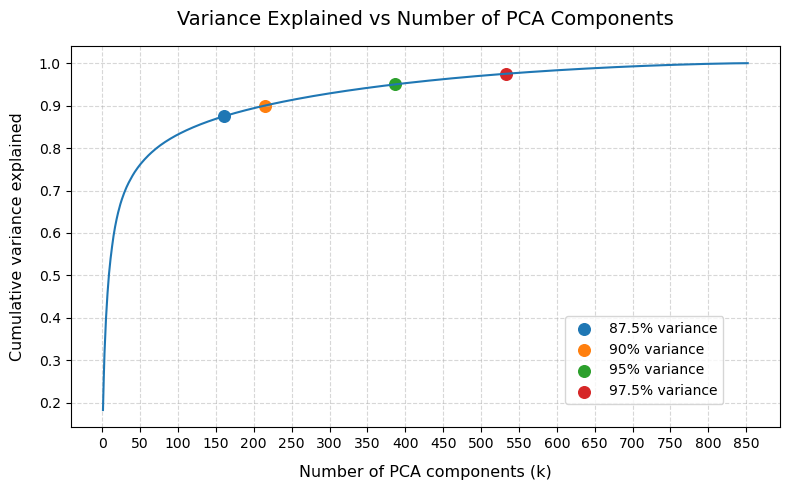

In [14]:
# Plot cumulative variance explained vs number of components
plt.figure(figsize=(8, 5))
plt.plot(k_range, cumulative_variances)

plt.scatter(optimal_k_87_5, cumulative_variances[optimal_k_87_5-1],
            s=70, label='87.5% variance', marker='o')
plt.scatter(optimal_k_90, cumulative_variances[optimal_k_90-1],
            s=70, label='90% variance', marker='o')
plt.scatter(optimal_k_95, cumulative_variances[optimal_k_95-1],
            s=70, label='95% variance', marker='o')
plt.scatter(optimal_k_97_5, cumulative_variances[optimal_k_97_5-1],
            s=70, label='97.5% variance', marker='o')

plt.xlabel('Number of PCA components (k)', fontsize=11.5, labelpad=10)
plt.ylabel('Cumulative variance explained', fontsize=11.5, labelpad=10)
plt.title('Variance Explained vs Number of PCA Components', fontsize=14, pad=15)
plt.grid(True, alpha=0.5, linestyle='--')
plt.xticks(range(0, after_tags + 1, 50))
plt.legend(bbox_to_anchor=(0.93, 0.31), fontsize=10)
plt.tight_layout()
plt.savefig('../notebooks/images/pca_cumulative_variance.png', dpi=300, bbox_inches='tight')
plt.show()


**<u>Comment:</u>**

Under the principle of parsimony and for the purpose of data reduction in our tag relevance representation, we opt for `k = 215`, which captures approximately 90%% of the variance in the original matrix. While this results in a loss of about 10% of the total variance (excluding the information already filtered out in the initial variance-based subsetting), it allows us to obtain a more compact and expressive movie vector that can be more efficiently handled during training and evaluation.


In [15]:
# Extract first 215 principal component
reduced_matrix = pca.transform(movie_tag_matrix)[:, :215]

# Create DataFrame for reduced matrix with appropriate column names
reduced_matrix_df = pd.DataFrame(
    reduced_matrix, 
    index=movie_tag_matrix.index, 
    columns=[f'tagPCA_{i}' for i in range(215)]
)

reduced_matrix_df.head(2)

,tagPCA_0,tagPCA_1,tagPCA_2,tagPCA_3,tagPCA_4,tagPCA_5,tagPCA_6,tagPCA_7,tagPCA_8,tagPCA_9,...,tagPCA_205,tagPCA_206,tagPCA_207,tagPCA_208,tagPCA_209,tagPCA_210,tagPCA_211,tagPCA_212,tagPCA_213,tagPCA_214
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.457184,1.187141,2.577074,0.692652,1.507113,1.470034,-0.176282,1.574248,0.604603,-1.528384,...,-0.039740,-0.044172,-0.030774,-0.046569,0.098974,0.053088,0.052955,0.057731,0.013880,-0.035702
2,-1.771258,1.011891,1.385247,0.625466,0.118349,0.406182,-0.409251,1.193931,0.160444,-0.956100,...,-0.095759,0.114656,-0.192151,0.064039,-0.044466,-0.056244,-0.062428,-0.023130,-0.025338,0.035913


In [16]:
# Left join reduced_matrix_df with movies_vector on movieId
movies_vector_complete = pd.merge(
    movies_vector,
    reduced_matrix_df,
    left_on='movieId',
    right_index=True,
    how='left'
)   
movies_vector_complete.head(2)

,movieId,year,decade,G_Action,G_Adventure,G_Animation,G_Children,G_Comedy,G_Crime,G_Documentary,...,tagPCA_205,tagPCA_206,tagPCA_207,tagPCA_208,tagPCA_209,tagPCA_210,tagPCA_211,tagPCA_212,tagPCA_213,tagPCA_214
0,1,1995.0,1990,0,1,1,1,1,0,0,...,-0.039740,-0.044172,-0.030774,-0.046569,0.098974,0.053088,0.052955,0.057731,0.013880,-0.035702
1,2,1995.0,1990,0,1,0,1,0,0,0,...,-0.095759,0.114656,-0.192151,0.064039,-0.044466,-0.056244,-0.062428,-0.023130,-0.025338,0.035913


In [17]:
# check for NaN values in movies_vector_std
nan_counts_movies_vector_std = movies_vector_complete.isna().sum()
print("NaN counts in movies_vector_std:\n", nan_counts_movies_vector_std[nan_counts_movies_vector_std > 0])

# Count number of rows with at least one NaN in user_vectors
n_rows_with_nan = movies_vector_complete.isna().any(axis=1).sum()
print(f"\nNumber of rows with at least one NaN in movies_vector_complete: {n_rows_with_nan}")

NaN counts in movies_vector_std:
 tagPCA_0      35
tagPCA_1      35
tagPCA_2      35
tagPCA_3      35
tagPCA_4      35
              ..
tagPCA_210    35
tagPCA_211    35
tagPCA_212    35
tagPCA_213    35
tagPCA_214    35
Length: 215, dtype: int64

Number of rows with at least one NaN in movies_vector_complete: 35


The remaining missing values correspond to 35 movies for which all tag-related information was removed during variance-based filtering due to their niche nature. As a result, no tag signal remains after the PCA projection, leading to undefined component values. These entries are filled with zero to preserve evaluation stability. Since PCA is mean-centered, this choice represents the absence of tag information rather than the introduction of spurious signal and is unlikely to affect the overall results given the small proportion of affected movies.

In [18]:
# Fill NaNs with zeros for movies that had no tag info in PCA
movies_vector_complete.fillna(0, inplace=True)

# Save non-normalized movies_vector_complete
movies_vector_complete.to_csv('../data/processed/movies_vector_not_std.csv', index=False)

### <u>1.3 Standardization of columns</u>

Due to the different nature of certain variables such as year, decade, popularity, and Bayesian-adjusted rating, standardization is applied to each column by centering around the mean and dividing by the standard deviation. This ensures that all features have comparable magnitudes and behave well during similarity computation. In contrast, one-hot encoded genres do not require standardization, as their dummy structure is already suitable for similarity measures. The PCA components are also left as-is, since they are already centered and provide an expressive, structured representation with magnitudes comparable to the other standardized variables.


In [19]:
# Stanadrdize year, decade, popularity, Bayes_rating
scaler = StandardScaler()
movies_vector_complete[['year', 'decade', 'popularity', 'Bayes_rating']] = scaler.fit_transform(
    movies_vector_complete[['year', 'decade', 'popularity', 'Bayes_rating']]
)

# Save the final movies_vector_complete dataframe
movies_vector_complete.to_csv('../data/processed/movies_vector_std.csv', index=False)



In [20]:
movies_vector_std = pd.read_csv('../data/processed/movies_vector_std.csv', index_col=0)
movies_vector_std.head(2)

,year,decade,G_Action,G_Adventure,G_Animation,G_Children,G_Comedy,G_Crime,G_Documentary,G_Drama,...,tagPCA_205,tagPCA_206,tagPCA_207,tagPCA_208,tagPCA_209,tagPCA_210,tagPCA_211,tagPCA_212,tagPCA_213,tagPCA_214
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.162763,0.136589,0,1,1,1,1,0,0,0,...,-0.039740,-0.044172,-0.030774,-0.046569,0.098974,0.053088,0.052955,0.057731,0.013880,-0.035702
2,0.162763,0.136589,0,1,0,1,0,0,0,0,...,-0.095759,0.114656,-0.192151,0.064039,-0.044466,-0.056244,-0.062428,-0.023130,-0.025338,0.035913


## <u>2. User Vector</u>

Given the preparation of the movie vectors, building the user vector representation is straightforward. For each user, we compute a weighted average of the movie vectors for the movies they have rated, where the weights are the **user-centered ratings**. Specifically, the user vector $\mathbf{u}_i$ for user $i$ is calculated as:

<br>

$$
\mathbf{u}_i = \frac{\sum_{j \in M_i} (r_{ij} - \bar{r}_i) \, \mathbf{v}_j}{\sum_{j \in M_i} |r_{ij} - \bar{r}_i|}
$$

where:

- $M_i$ is the set of movies rated by user $i$ in the training set
- $r_{ij}$ is the rating given by user $i$ to movie $j$  
- $\bar{r}_i$ is the mean rating of user $i$ across all rated movies in the training set
- $\mathbf{v}_j$ is the movie vector for movie $j$  

<br>

The decision to **center the ratings** for each user is motivated by the principle of **user bias correction**. Different users may systematically give higher or lower ratings, and centering ensures that the user vector reflects the **relative preference of a user** rather than their absolute rating scale. This helps produce more accurate similarity measures and better predictions in content-based filtering.


In [21]:
# Compute mean rating per user
user_means = train_df.groupby('userId')['rating'].mean()

# Assign mean ratings to users

# Build centered rating column to train_df
train_df = train_df.copy()
train_df['ratintg_centered'] = train_df['rating'] - train_df['userId'].map(user_means)

# Inner join train_df with movies_vector_std on movieId
train_df_with_vectors = train_df.merge(
    movies_vector_std,
    left_on='movieId',
    right_index=True,
    how='inner'
)

train_df_with_vectors.head(2)

,userId,movieId,rating,ratintg_centered,year,decade,G_Action,G_Adventure,G_Animation,G_Children,...,tagPCA_205,tagPCA_206,tagPCA_207,tagPCA_208,tagPCA_209,tagPCA_210,tagPCA_211,tagPCA_212,tagPCA_213,tagPCA_214
0,27,2683,5.0,1.170213,0.394642,0.136589,1,1,0,0,...,-0.028561,-0.075922,0.018457,0.089802,0.020440,-0.020222,-0.155477,0.000945,-0.071544,-0.004169
1,27,2997,3.0,-0.829787,0.394642,0.136589,0,0,0,0,...,0.112827,0.098126,0.027451,0.114341,0.112964,-0.064066,0.010358,0.180521,0.071353,0.203021


In [22]:
# Select all the features columns from movies_vector_std
features_columns =  movies_vector_std.columns

# Multiply each feature by the centered rating per user by row
weighted_features = train_df_with_vectors[features_columns].multiply(train_df_with_vectors['ratintg_centered'], axis=0)

# Numerator by summing weighted features within userId
user_numerators = weighted_features.groupby(train_df_with_vectors['userId']).sum()

# Denominator by summing absolute centered ratings within userId
user_denominators = train_df_with_vectors.groupby('userId')['ratintg_centered'].apply(lambda x: x.abs().sum())

# User profiles by dividing numerators by denominators
user_vectors = user_numerators.div(user_denominators, axis=0)

# Replace NaNs caused by zero denominator with 0 in users with no rating variance
user_vectors = user_vectors.fillna(0)

# Concatenate user means
user_vectors = pd.concat([user_vectors, user_means.rename('user_mean_rating')], axis=1)

# Save user_vectors to csv
user_vectors.to_csv('../data/processed/user_vectors.csv')

In [23]:
# Load and display user_vectors
user_vectors = pd.read_csv('../data/processed/user_vectors.csv', index_col=0)
user_vectors.head(2)

,year,decade,G_Action,G_Adventure,G_Animation,G_Children,G_Comedy,G_Crime,G_Documentary,G_Drama,...,tagPCA_206,tagPCA_207,tagPCA_208,tagPCA_209,tagPCA_210,tagPCA_211,tagPCA_212,tagPCA_213,tagPCA_214,user_mean_rating
userId,,,,,,,,,,,,,,,,,,,,,
27,-0.109584,-0.161600,-0.145213,-0.216041,-0.035252,-0.035252,0.093790,0.061125,0.005175,-0.018111,...,-0.014616,-0.012032,0.016553,0.015467,0.010919,0.009699,0.004407,-0.008516,-0.019542,3.829787
29,-0.054538,-0.049551,0.035144,0.016069,0.037736,0.019075,-0.081588,0.052872,-0.007361,0.058159,...,-0.001878,-0.000480,-0.015788,0.006749,0.007017,0.000353,0.007584,0.018472,-0.013712,3.577236


## <u>3. Rating Prediction</u>

To translate the similarity between a user profile $\mathbf{v}_u$ and an unseen movie $\mathbf{v}_i$ into a predicted rating, we apply a **linear piecewise mapping** based on **group-wise similarity aggregation**. The rationale behind this approach is to account for **user-specific bias** while ensuring that predicted ratings stay within the original rating scale $[R_{\min}, R_{\max}]$, and to balance the contribution of different feature groups in the similarity computation. The main principles are described and implemented as follow:

<br>

1. **User-centered rating:**  
   For each user, we compute the mean rating $\bar{r}_u$ and center the ratings used to build the user profile. This captures individual user tendencies to rate higher or lower than the overall population.

<br>

2. **Group-wise similarity computation:**  

    * The movie vector is divided into distinct feature groups (movie_info, genres, and tag-based PCA components). Cosine similarity is calculated **separately for each group**:

        <br>

        $$
        s_{u,i}^{(g)} = \text{cosine\_similarity}(\mathbf{v}_u^{(g)}, \mathbf{v}_i^{(g)})
        $$

        where $g$ indexes the feature group.

        <br>

        * The **overall similarity** between a user and a movie is computed as a weighted combination of the group-wise similarities:

        <br>

        $$
        s_{u,i} = \sum_{g=1}^{G} w_g \, s_{u,i}^{(g)}, \quad \sum_{g=1}^{G} w_g = 1
        $$

        where $s_{u,i}^{(g)}$ is the similarity for group $g$, $w_g$ is its weight, and $G$ is the number of groups.  

        <br>

3. **Piecewise linear mapping to ratings:**  
   The combined similarity is mapped back to the rating scale:

<br>

   $$
   \hat{r}_{u,i} =
   \begin{cases} 
   \bar{r}_u + s_{u,i} \cdot (R_{\max} - \bar{r}_u), & s_{u,i} > 0 \\[1em]
   \bar{r}_u + s_{u,i} \cdot (\bar{r}_u - R_{\min}), & s_{u,i} \le 0
   \end{cases}
   $$

   <br>

   - Positive similarity moves the predicted rating above the user mean toward the maximum rating.  
   - Negative similarity moves the predicted rating below the user mean toward the minimum rating.  
   - Zero similarity results in the predicted rating equal to the user's mean.

<br>

In [24]:
def predict_ratings(eval_df, user_vectors, movie_vectors, weights=(1,1,1)):

    """
    Predict ratings using cosine similarity and piecewise linear mapping.
    Similarity is computed over three subgroups: stats, genres, tags.
    Weights specify the contribution of each subgroup (stats, genres, tags).
    
    Args:
        eval_df (pd.DataFrame): Must contain 'userId', 'movieId', 'rating'
        user_vectors (pd.DataFrame): index=userId, columns=all features + 'user_mean_rating'
        movie_vectors (pd.DataFrame): index=movieId, columns=all features
        weights (tuple/list of 3): weights for (stats, genres, tags), will be normalized to sum 1
        
    Returns:
        float: RMSE
    """

    # Extract columns for each feature subgroup
    stats_feat = ['year', 'decade', 'popularity', 'Bayes_rating']
    genre_feat = [c for c in movie_vectors.columns if c.startswith('G_')]
    tag_feat   = [c for c in movie_vectors.columns if c.startswith('tagPCA_')]

    subgroups = [stats_feat, genre_feat, tag_feat]

    # Normalize weights
    weights = np.array(weights)
    weights = weights / np.sum(weights)

    # Map userId to index
    user_idx = eval_df['userId'].map(lambda x: user_vectors.index.get_loc(x)).values
    user_means = user_vectors.loc[eval_df['userId'], 'user_mean_rating'].values

    # Compute subgroup similarities
    group_sims = []
    for grp in subgroups:
        U = user_vectors[grp].values[user_idx]
        M = movie_vectors.loc[eval_df['movieId'], grp].values
        U_norm = np.linalg.norm(U, axis=1)
        M_norm = np.linalg.norm(M, axis=1)
        U_norm = np.where(U_norm == 0, 1e-8, U_norm)
        M_norm = np.where(M_norm == 0, 1e-8, M_norm)
        sims = np.sum(U * M, axis=1) / (U_norm * M_norm + 1e-8)
        group_sims.append(sims)

    # Weighted average of subgroup similarities
    combined_sims = np.sum(np.vstack(group_sims).T * weights, axis=1)

    # Map similarity to rating using piecewise linear function
    R_min, R_max = 0.5, 5
    preds = np.where(
        combined_sims > 0,
        user_means + combined_sims * (R_max - user_means),
        user_means + combined_sims * (user_means - R_min)
    )

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(eval_df['rating'], preds))
    return rmse


## <u>4. Hyperparameter tuning</u>

Hyperparameter tuning is performed over the validation set to evaluate the contribution of different subsets of features in predicting user ratings. The goal of this validation is to measure the marginal effect of each feature group and understand how much each component improves model performance.

To do so, we create the following feature configurations using the movie vectors and assign **initial equal weights** across subgroups:

- **movie_info:** Includes only the movie information (100% weight)
- **movie_info_genres:** Includes movie information and the 19 one-hot encoded genres (initially 50% movie_info, 50% genres)
- **movie_info_tags:** Includes movie information and the 150 PCA components extracted from `genome_scores.csv`, representing the most relevant tag scores (initially 50% movie_info, 50% tags)
- **genres_tags:** Includes only genres and tags without movie information (initially 50% genres, 50% tags)
- **full_features:** Includes movie information, genres, and tags (initially equal weights for all three subgroups: 1/3 each)

For reference, the **movie information** used in all settings is rigorously standardized and consists of:  
- `year` — the release year of the movie  
- `decade` — the decade derived from the release year  
- `popularity` — the natural logarithm of the number of reviews, reflecting how widely the movie is known  
- `Bayes_rating` — the Bayesian-adjusted rating computed over the training set, capturing overall movie quality while mitigating the effect of movies with very few ratings

<br>

The initial weights are **equal or intuitive** starting points for evaluating subgroup contributions. Subsequently, we perform a **grid search over the validation set** to find the optimal weights for each subgroup, effectively performing a cross-validation over feature importance. This allows the model to balance the influence of movie information, genres, and tags for maximal predictive performance.


In [25]:
# Import user_vectors, movies_vector_std, val_df
user_vectors = pd.read_csv('../data/processed/user_vectors.csv', index_col=0)
movies_vector_std = pd.read_csv('../data/processed/movies_vector_std.csv', index_col=0)
val_df = pd.read_csv('../data/processed/val_df.csv')

### <u>4.1 Equally weighted similarity across feature subgroups</u> 

In [26]:
weights_dict = {
    'movie-info':               (1, 0, 0),  # only stats
    'movie-info_and_genres':    (1, 1, 0),  # stats + genres
    'movie-info_and_tags':      (1, 0, 1),  # stats + tags
    'genres_and_tags':          (0, 1, 1),  # genres + tags only
    'full_features':            (1, 1, 1)   # stats + genres + tags equally
}

# Dictionary to store validation RMSE results
val_results = {}

# Loop through each feature configuration
for label, weights in weights_dict.items():
    # Predict ratings on the validation set using the specified weights
    rmse = predict_ratings(
        eval_df=val_df,
        user_vectors=user_vectors,
        movie_vectors=movies_vector_std,
        weights=weights
    )

    # Store RMSE
    val_results[label] = rmse

    # Print validation MSE
    print(f"Validation RMSE using {label.replace('_', ' ')}: {rmse:.4f}")

Validation RMSE using movie-info: 1.3386
Validation RMSE using movie-info and genres: 0.9856
Validation RMSE using movie-info and tags: 1.0282
Validation RMSE using genres and tags: 0.9131
Validation RMSE using full features: 0.9245


### <u>4.2 Hyperparameter tuning on subgroup weights</u>

In [27]:
# Evaluate all combinations of weights from 0 to 5 across three feature groups
steps = range(0, 7)
total_steps = len(steps) ** 3 - 1
progress = total_steps // 10

best_rmse = float('inf')
best_weights = None
val_results = {}
tracker = 0

# Loop over all combinations
for w_stats, w_genres, w_tags in itertools.product(steps, repeat=3):
    tracker += 1
    
    # Print progress every 10%
    if tracker ==1 or tracker % progress ==0:
        print(f"Evaluating combination {tracker} of {total_steps}...")

    # Skip all-zero weights
    if w_stats + w_genres + w_tags == 0:
        continue
    
    # Weights are normalized in the predict_ratings function
    weights = (w_stats, w_genres, w_tags)
    
    # Predict RMSE
    rmse = predict_ratings(
        eval_df=val_df,
        user_vectors=user_vectors,
        movie_vectors=movies_vector_std,
        weights=weights
    )
    
    # Store result
    val_results[weights] = rmse
    
    # Update best
    if rmse < best_rmse:
        best_rmse = rmse
        best_weights = weights

print(f"\nBest validation RMSE: {best_rmse:.4f}")
print(f"Best weights combination (stats, genres, tags): {best_weights}")

Evaluating combination 1 of 342...
Evaluating combination 34 of 342...
Evaluating combination 68 of 342...
Evaluating combination 102 of 342...
Evaluating combination 136 of 342...
Evaluating combination 170 of 342...
Evaluating combination 204 of 342...
Evaluating combination 238 of 342...
Evaluating combination 272 of 342...
Evaluating combination 306 of 342...
Evaluating combination 340 of 342...

Best validation RMSE: 0.8865
Best weights combination (stats, genres, tags): (1, 3, 6)


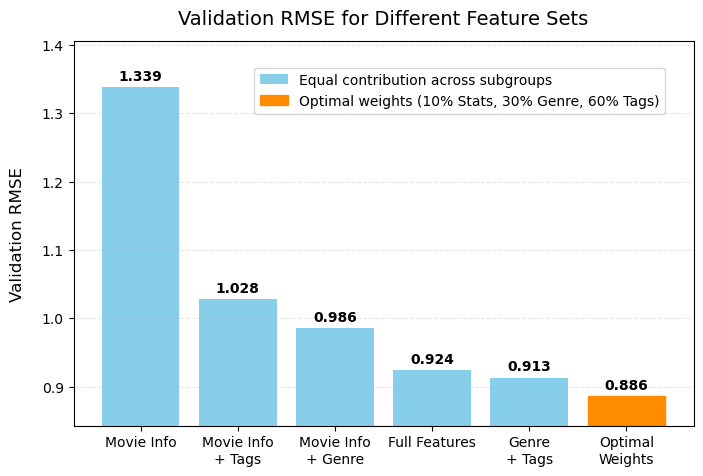

In [39]:
# Equally weighted features Validation RMSE results
val_results = {
    'movie_info': 1.3386,
    'movie_info_genres': 0.9856,
    'movie_info_tags':  1.0283,
    'genres_tags': 0.9131,
    'full_features': 0.9245
}

# Mapping feature keys into text labels
label_mapping = {
    'movie_info': 'Movie Info',
    'movie_info_genres': 'Movie Info\n+ Genre',
    'movie_info_tags': 'Movie Info\n+ Tags',
    'genres_tags': 'Genre\n+ Tags',
    'full_features': 'Full Features'
}

# Prepare data
features = [label_mapping[f] for f in val_results.keys()]
rmse_values = list(val_results.values())

# Add the optimal weight result
features.append('Optimal\nWeights')
rmse_values.append(0.8865)

# Sort by RMSE in descending order (highest first), excluding Optimal
sorted_idx = sorted(range(len(features)-1), key=lambda i: rmse_values[i], reverse=True)
features_sorted = [features[i] for i in sorted_idx] + [features[-1]]  
rmse_sorted = [rmse_values[i] for i in sorted_idx] + [rmse_values[-1]]

# Plot
plt.figure(figsize=(8,5))
bars = plt.bar(features_sorted, rmse_sorted, color='skyblue')
bars[-1].set_color('#FF8C00') 

plt.title("Validation RMSE for Different Feature Sets", pad=12, fontsize=14)
plt.ylabel("Validation RMSE", labelpad=12, fontsize=12)
plt.ylim(min(rmse_sorted)*0.95, max(rmse_sorted)*1.05)

# Annotate bars with RMSE values
for i, v in enumerate(rmse_sorted):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', fontweight='bold', fontsize=10)

# Custom legend
handles = [bars[0], bars[-1]]
labels = ['Equal contribution across subgroups', 'Optimal weights (10% Stats, 30% Genre, 60% Tags)']
plt.legend(handles=handles, labels=labels, bbox_to_anchor=(0.965, 0.949), fontsize=10)

plt.grid(axis='y', alpha=0.3, linestyle='--')

# Save plot
plt.savefig('../notebooks/images/validation_rmse_feature_sets_content.png', dpi=300, bbox_inches='tight')
plt.show()


**<u>Commnent:</u>**

From the validation results we can see that equally weighted contributions across feature subgroups are suboptimal. Allocating too much weight to movie information reduces the benefit of the additional information captured by genres and tags. Among the equally weighted configurations the genre and tags combination achieves the lowest validation RMSE reflecting the higher predictive value of these features. The optimal weight allocation obtained via grid search confirms this with a high weight assigned to tags, a moderate weight to genres, and a smaller contribution to movie info. Surprisingly, No subgroup is completely excluded, indicating that each provides some valuable information for predicting user ratings.

## <u>5.0 Model Evaluation </u>

In [36]:
# start time
start = time.perf_counter()

# Buffer 10 seconds to account for movie and vector construction time
time_buffer = 10

# evaluate on test set with optimal features
rmse_test = predict_ratings(test_df, user_vectors, movies_vector_std, weights=best_weights)
rmse_warm_test = predict_ratings(warm_test_df, user_vectors, movies_vector_std, weights=best_weights)
rmse_cold_test = predict_ratings(cold_test_df, user_vectors, movies_vector_std, weights=best_weights)

# end time
end = time.perf_counter()

# Elapsed time
elapsed_time = end - start + time_buffer

In [37]:
print(
    f"Model performance (content-based) on test set (using optimal weights):\n"
    f"RMSE Total: {rmse_test:.4f}\n"
    f"RMSE Warm:  {rmse_warm_test:.4f}\n"
    f"RMSE Cold:  {rmse_cold_test:.4f}\n"
    f"Elapsed time: {elapsed_time:.1f} seconds"
)

Model performance (content-based) on test set (using optimal weights):
RMSE Total: 0.9013
RMSE Warm:  0.9002
RMSE Cold:  0.9193
Elapsed time: 12.5 seconds


## <u> 6.0 Summary of findings </u>

### <u>6.1 Model performance</u>


<div style="display: flex; justify-content: left; align-items: flex-start;">
  <img src="images/pca_cumulative_variance.png" style="height: 350px; margin-right: 20px;">
  <img src="images/validation_rmse_feature_sets_content.png" style="height: 350px;">
</div>




<br>

<table border="1" cellpadding="5" cellspacing="0" style="text-align: center;">
  <tr>
    <th>Model Type</th>
    <th>Validation RMSE</th>
    <th colspan="3">Test RMSE</th>
    <th>Elapsed Time (s)</th>
  </tr>
  <tr>
    <th></th>
    <th>Total</th>
    <th>Total</th>
    <th>Warm</th>
    <th>Cold</th>
    <th></th>
  </tr>
  <tr>
    <td>Content-based Filtering</td>
    <td>0.8865</td>
    <td>0.9014</td>
    <td>0.9002</td>
    <td>0.9193</td>
    <td>12.5</td>
  </tr>
</table>


### <u> 6.2 Discussion </u>


From the results we can observe that the content-based model is highly time-efficient, especially considering the brief overhead introduced by creating the movie and user vectors. Its reliance on matrix multiplication and parallel computation makes it well-suited for fast rating predictions and immediate feedback, which is ideal for live recommendation systems or dynamic environments where the training set can be expanded and retrained quickly. Compared to memory-based collaborative filtering, the model achieves slightly higher RMSE on the warm set while improving performance on the cold set and overall efficiency.

The model handles sparse user data effectively, explaining why cold test RMSE is almost as good as more complex methods like Funk SVD. Its strength lies in representing individual tastes through user vectors rather than relying on user-user comparisons. This flexibility highlights potential for hybrid approaches, where it can complement other methods. Further improvements could focus on tuning the number of PCA components and the proportion of retained tag information to enhance cold-start performance while ensuring that the overall signal is not diluted.